In [160]:
from PIL import Image
import datetime
import requests

# Downloading the rain data

In [175]:
def get_date_time(delta=0):
    current = datetime.datetime.now()
    minute = current.minute if current.minute%5 == 0 else current.minute -  (current.minute%5)
    minute = minute - delta
    return "%d%s%s%d%d0000" % (current.year, "%02d"% current.month, "%02d"%current.day, current.hour, minute)

In [182]:
def download_rain_file():
    filename = "dpsri_70km_%sdbr.dpsri.png" % get_date_time(5)
    url = "https://www.nea.gov.sg/docs/default-source/rain-area/%s" % (filename)
    r=requests.get(url)
    with open(filename,'wb') as f:
        f.write(r.content)
    return filename

In [183]:
filename = download_rain_file()

# Processing the image

In [184]:
im=Image.open(filename)

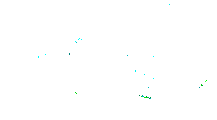

In [185]:
im

Geographic extent of the picture

In [186]:
upper_left_x = 103.5544
lower_right_x = 104.1337
upper_left_y = 1.4771
lower_right_y = 1.1530

In [187]:
x,y = im.size

Find the lat long given the pixel location

In [188]:
def find_x_pixel(ul_x,lr_x, x_len, x):
    range_x = lr_x - ul_x
    return x/float(x_len) * range_x +ul_x

In [189]:
def find_y_pixel(ul_y,lr_y, y_len, y):
    range_y = ul_y- lr_y
    return ul_y- (y/float(y_len) * range_y)

In [190]:
location= (103.8752, 1.3715)

Creating the GeoDataFrames for use in the intersection calculation

In [191]:
import geopandas as gpd
from shapely.geometry import Point

Creating the Rain data frame

In [192]:
arr_points=[]
for px in range(x):
    for py in range(y):
        (r,g,b,a) = im.getpixel((px,py))
        if a==255:
            point = Point((find_x_pixel(upper_left_x, lower_right_x,x, px), 
                           find_y_pixel(upper_left_y,lower_right_y,y,py)))
            arr_points.append({"type":"rain","geometry":point})

In [193]:
rain_df=gpd.GeoDataFrame(data=arr_points,crs="EPSG:4326")

<AxesSubplot:>

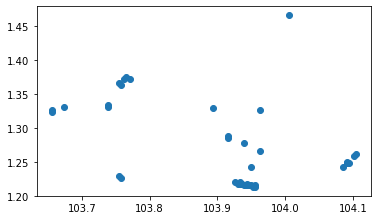

In [194]:
rain_df.plot()

In [195]:
rain_df.to_file("rain.shp")

My Location

In [196]:
myLoc = Point(location)

Creating a 1km buffer zone the number in buffer is in degrees. Need to convert length to degrees

In [197]:
buf = myLoc.buffer(0.009)

In [198]:
with_buffer = []

In [199]:
with_buffer.append({"type":"location","geometry":buf})

In [200]:
print(myLoc)

POINT (103.8752 1.3715)


In [201]:
newDf=gpd.GeoDataFrame(data=with_buffer,crs="EPSG:4326")

In [203]:
newDf.to_file("location.shp")

Perform the intersection

In [204]:
intersect = gpd.overlay(gdf,newDf,how="intersection")

If len is 0 means no rain near

In [207]:
len(intersect)

0

In [205]:
intersect.plot()

d:\anaconda3\envs\webcollect\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


<AxesSubplot:>

ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 1 Axes>

In [124]:
non_hit_location = (103.8853, 1.3904)

In [130]:
no_hit=Point(non_hit_location)
no_hit_df=gpd.GeoDataFrame(data=[{"geometry":no_hit}],crs="EPSG:4326")

In [132]:
intersect = gpd.overlay(gdf,no_hit_df,how="intersection")

In [134]:
len(intersect)

0